# Preprocessing and Feature Extraction

## Preprocessing

In [14]:
import os
from PIL import Image, ImageOps

# Path to the root directory containing the "CORROSION" and "NOCORROSION" folders
root_dir = './data'

# Define the target size
target_size = (256, 256)

# Output directory for resized images
output_dir = './resize_data'

# Function to resize and add padding to an image
def resize_and_add_padding(image_path, output_path):
    image = Image.open(image_path)
    image = ImageOps.fit(image, target_size, method=0, bleed=0.0, centering=(0.5, 0.5))
    image.save(output_path)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate through the "CORROSION" and "NOCORROSION" folders
for class_folder in ['CORROSION', 'NOCORROSION']:
    class_dir = os.path.join(root_dir, class_folder)

    # Create a subdirectory in the output directory for each class
    class_output_dir = os.path.join(output_dir, class_folder)
    os.makedirs(class_output_dir, exist_ok=True)

    # Iterate through the images in the class folder
    for filename in os.listdir(class_dir):
        if filename.endswith('.jpg'):  # Adjust the file extension as needed
            input_image_path = os.path.join(class_dir, filename)
            output_image_path = os.path.join(class_output_dir, filename)
            resize_and_add_padding(input_image_path, output_image_path)
            print(f"Resized: {input_image_path} -> {output_image_path}")


Resized: ./data/CORROSION/05f117f458.jpg -> ./resize_data/CORROSION/05f117f458.jpg
Resized: ./data/CORROSION/b23fe271d6.jpg -> ./resize_data/CORROSION/b23fe271d6.jpg
Resized: ./data/CORROSION/9691d33c97.jpg -> ./resize_data/CORROSION/9691d33c97.jpg
Resized: ./data/CORROSION/aced8405f9.jpg -> ./resize_data/CORROSION/aced8405f9.jpg
Resized: ./data/CORROSION/f2b3f0bac5.jpg -> ./resize_data/CORROSION/f2b3f0bac5.jpg
Resized: ./data/CORROSION/e7a083afde.jpg -> ./resize_data/CORROSION/e7a083afde.jpg
Resized: ./data/CORROSION/a3f1c9faeb.jpg -> ./resize_data/CORROSION/a3f1c9faeb.jpg
Resized: ./data/CORROSION/26bbfe477a.jpg -> ./resize_data/CORROSION/26bbfe477a.jpg
Resized: ./data/CORROSION/25b54fc79f.jpg -> ./resize_data/CORROSION/25b54fc79f.jpg
Resized: ./data/CORROSION/05a8b84d23.jpg -> ./resize_data/CORROSION/05a8b84d23.jpg
Resized: ./data/CORROSION/7efa1745ad.jpg -> ./resize_data/CORROSION/7efa1745ad.jpg
Resized: ./data/CORROSION/4e7f78e401.jpg -> ./resize_data/CORROSION/4e7f78e401.jpg
Resi

## Feature Extraction

### Gray Level Co-Occurance Matrix

In [1]:
import os
from skimage.feature import graycomatrix, graycoprops
import numpy as np
import pandas as pd
from skimage import io, color, img_as_ubyte

In [2]:
def compute_glcm_features(image_path):
    img = io.imread(image_path)
    gray = color.rgb2gray(img)
    image = img_as_ubyte(gray)
    
    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])  # 16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max() + 1
    matrix_cooccurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    contrast = graycoprops(matrix_cooccurrence, 'contrast')
    dissimilarity = graycoprops(matrix_cooccurrence, 'dissimilarity')
    homogeneity = graycoprops(matrix_cooccurrence, 'homogeneity')
    energy = graycoprops(matrix_cooccurrence, 'energy')
    correlation = graycoprops(matrix_cooccurrence, 'correlation')
    asm = graycoprops(matrix_cooccurrence, 'ASM')

    return {
        "Contrast": contrast,
        "Dissimilarity": dissimilarity,
        "Homogeneity": homogeneity,
        "Energy": energy,
        "Correlation": correlation,
        "ASM": asm
    }

In [3]:
# Define the paths to your dataset directories
corrosion_dir = "resize_data/CORROSION"
nocorrosion_dir = "resize_data/NOCORROSION"

# Function to compute GLCM features for a directory of images
def compute_glcm_features_for_directory(directory, label):
    features_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # Modify the file extension as needed
            image_path = os.path.join(directory, filename)
            features = compute_glcm_features(image_path)
            features["Label"] = label  # Add the label
            features_list.append(features)
    return features_list

# Compute GLCM features for both classes
corrosion_features = compute_glcm_features_for_directory(corrosion_dir, "corrosion")
nocorrosion_features = compute_glcm_features_for_directory(nocorrosion_dir, "nocorrosion")

# Combine features for both classes
all_features = corrosion_features + nocorrosion_features

# Create a DataFrame from the features
feature_df = pd.DataFrame(all_features)

# Save the DataFrame to a CSV file
feature_df.to_csv("./features/glcm_features.csv", index=False)


In [4]:
import pandas as pd

# Read the original DataFrame
df_data = pd.read_csv('./features/glcm_features.csv')

# Extract the 'Contrast' column and remove square brackets
df_data['Contrast'] = df_data['Contrast'].str.replace('[', '').str.replace(']', '')
df_data['Dissimilarity'] = df_data['Dissimilarity'].str.replace('[', '').str.replace(']', '')
df_data['Homogeneity'] = df_data['Homogeneity'].str.replace('[', '').str.replace(']', '')
df_data['Energy'] = df_data['Energy'].str.replace('[', '').str.replace(']', '')
df_data['Correlation'] = df_data['Correlation'].str.replace('[', '').str.replace(']', '')
df_data['ASM'] = df_data['ASM'].str.replace('[', '').str.replace(']', '')



# Split the 'Contrast' column values by whitespace and expand them into separate columns
df_data[['Contrast0', 'Contrast45', 'Contrast90', 'Contrast135']] = df_data['Contrast'].str.split(expand=True)
df_data[['Dissimilarity0', 'Dissimilarity45', 'Dissimilarity90', 'Dissimilarity135']] = df_data['Dissimilarity'].str.split(expand=True)
df_data[['Homogeneity0', 'Homogeneity45', 'Homogeneity90', 'Homogeneity135']] = df_data['Homogeneity'].str.split(expand=True)
df_data[['Energy0', 'Energy45', 'Energy90', 'Energy135']] = df_data['Energy'].str.split(expand=True)
df_data[['Correlation0', 'Correlation45', 'Correlation90', 'Correlation135']] = df_data['Correlation'].str.split(expand=True)
df_data[['ASM0', 'ASM45', 'ASM90', 'ASM135']] = df_data['ASM'].str.split(expand=True)


# Drop the original 'Contrast' column
df_data.drop(columns=['Contrast'], inplace=True)
df_data.drop(columns=['Dissimilarity'], inplace=True)
df_data.drop(columns=['Homogeneity'], inplace=True)
df_data.drop(columns=['Energy'], inplace=True)
df_data.drop(columns=['Correlation'], inplace=True)
df_data.drop(columns=['ASM'], inplace=True)


# Save the new DataFrame to a new CSV file
new_csv_filename = './features/glcm_features_split.csv'
df_data.to_csv(new_csv_filename, index=False)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset (assuming 'glcm_features_new.csv')
data = pd.read_csv('./features/glcm_features_split.csv')

# Extract features and labels
X = data.drop('Label', axis=1)
y = data['Label']

# Encode labels (corrosion, no corrosion) to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(300, 50), max_iter=2000, random_state=42, verbose=True, solver='adam',alpha=0.0001)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")


Iteration 1, loss = 0.68356553
Iteration 2, loss = 0.63372767
Iteration 3, loss = 0.59740192
Iteration 4, loss = 0.56701509
Iteration 5, loss = 0.54424078
Iteration 6, loss = 0.53218771
Iteration 7, loss = 0.52844752
Iteration 8, loss = 0.52346546
Iteration 9, loss = 0.51471134
Iteration 10, loss = 0.51411986
Iteration 11, loss = 0.51764994
Iteration 12, loss = 0.52177556
Iteration 13, loss = 0.51299619
Iteration 14, loss = 0.50841783
Iteration 15, loss = 0.50804045
Iteration 16, loss = 0.49921851
Iteration 17, loss = 0.50053236
Iteration 18, loss = 0.49504968
Iteration 19, loss = 0.49564837
Iteration 20, loss = 0.49414850
Iteration 21, loss = 0.49150638
Iteration 22, loss = 0.49430663
Iteration 23, loss = 0.48933859
Iteration 24, loss = 0.48776358
Iteration 25, loss = 0.48698624
Iteration 26, loss = 0.48447616
Iteration 27, loss = 0.50208853
Iteration 28, loss = 0.49051836
Iteration 29, loss = 0.49822174
Iteration 30, loss = 0.48348168
Iteration 31, loss = 0.48468109
Iteration 32, los

### Saving The Model

In [7]:
import joblib

# Save the trained MLP classifier to a file
model_filename = './model/mlp_classifier_model.joblib'
joblib.dump(mlp_classifier, model_filename)

['./model/mlp_classifier_model.joblib']

### Main Code Prediction

HASIL PREDIKSI: NoCorrosion


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


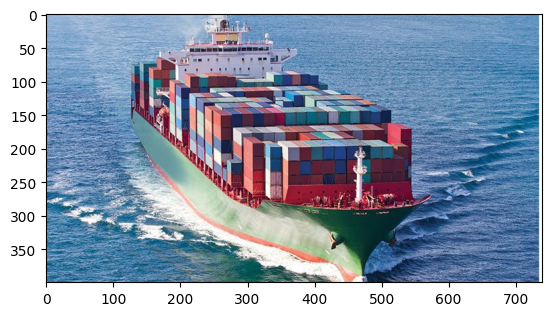

In [8]:
import joblib
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

# Load the trained MLP classifier model from a file
model_filename = './model/mlp_classifier_model.joblib'
loaded_mlp_classifier = joblib.load(model_filename)

image_path = './data/NOCORROSION/100e35cf19.jpg'
target_size = (256, 256)

image = Image.open(image_path)

# Resize Image
image_new = ImageOps.fit(image, target_size, method=0, bleed=0.0, centering=(0.5, 0.5))
temp_image_path = './temp_resized_image.jpg'
image_new.save(temp_image_path)

# Extract GLCM Value
features = compute_glcm_features(temp_image_path)

# Initialize a new dictionary to store the transformed features
transformed_features = {}

# Define a list of angles
angles = ['0', '45', '90', '135']

# Iterate through the features and angles to create new labels
for feature_name, feature_values in features.items():
    for i, angle in enumerate(angles):
        new_label = f'{feature_name}{angle}'
        transformed_features[new_label] = feature_values[0][i]

# Transform the dictionary to a 1D NumPy array
transformed_features_array = np.array(list(transformed_features.values())).reshape(1, -1)

# Make predictions using the loaded model
predictions = loaded_mlp_classifier.predict(transformed_features_array)

if predictions[0] == 0:
    print("HASIL PREDIKSI: Corrosion")
else:
    print("HASIL PREDIKSI: NoCorrosion")

# Close and remove the temporary image file
image_new.close()
if os.path.exists(temp_image_path):
    os.remove(temp_image_path)

image = plt.imread(image_path)
plt.imshow(image)